## Brute-force diode parameter extraction

In [1]:
import sys
sys.path.append('..')
IV_path = os.path.join('..', 'pvops', 'iv')
sys.path.append(IV_path)

from pvops.iv import simulator, extractor

### Step 1: Collect your IV curves. 

In this case, we simulate some curves, but you can replace this step by reading in your own data, if wanted.

In [2]:
sim = simulator.Simulator(
                mod_specs = {
                            'Jinko_Solar_Co___Ltd_JKM270PP_60': {'ncols': 6,
                                                                    'nsubstrings': 3
                                                                }
                            }
)

sim.build_strings({'Unstressed': ['pristine']*12})

N = 100
dicts = {'E':       {'mean': 800,
                        'std': 500,
                        'low': 400,
                        'upp': 1100
                    },
         'Tc':      {'mean': 30,
                      'std': 5,
                    },
         'Rs_mult': {'mean': 1.3,
                    'std': 0.6,
                    'low': 0.9,
                    'upp': 1.5
                    },
         'Rsh_mult': {'mean': 0.8,
                    'std': 0.9,
                    'low': 0.3,
                    'upp': 1.0
                    },
        'Il_mult': {'mean': 1.0,
                    'std': 0.5,
                    'low': 0.95,
                    'upp': 1.05
                    },
        'Io_mult': {'mean': 1.0,
                    'std': 0.6,
                    'low': 0.85,
                    'upp': 1.1
                    },
        'nnsvth_mult': {'mean': 1.0,
                        'std': 0.5,
                        'low': 0.85,
                        'upp': 1.1
                        }
        }
sim.generate_many_samples('pristine', N, dicts)
sim.simulate()

sim.print_info()

Simulating cells:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 1/1 [00:00<?, ?it/s]Condition list: (Cell definitions)
	[pristine]: 101 definition(s)

Modcell types: (Cell mappings on module)
	[pristine]: 1 definition(s)

String definitions (Series of modcells)
	[Unstressed]: 101 definition(s)




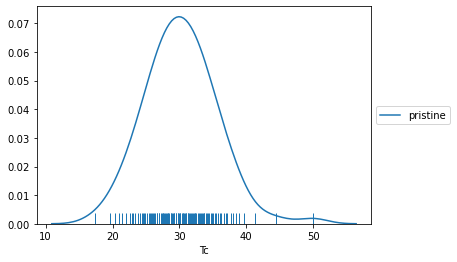

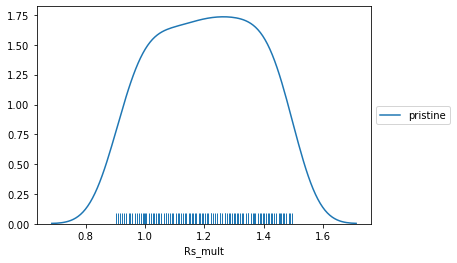

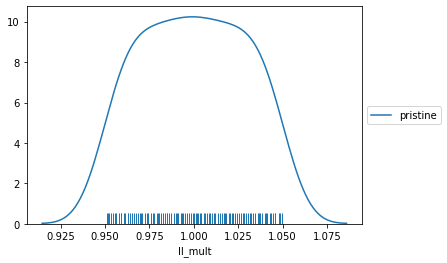

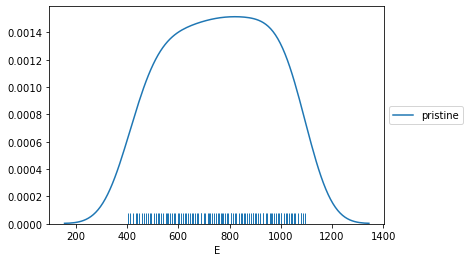

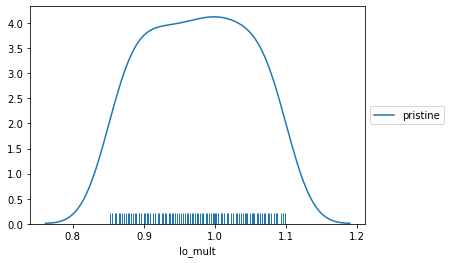

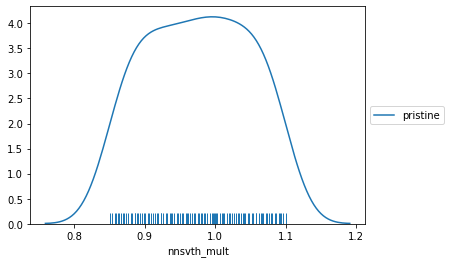

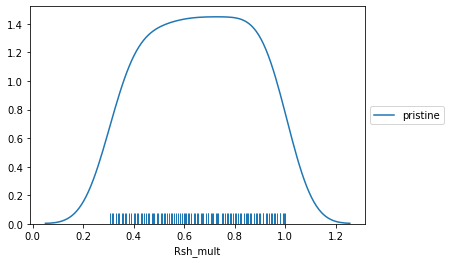

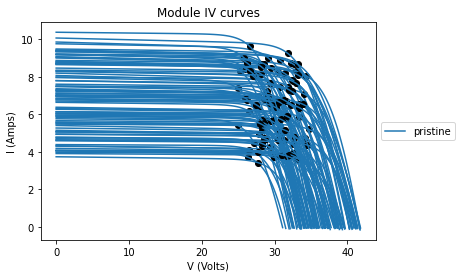

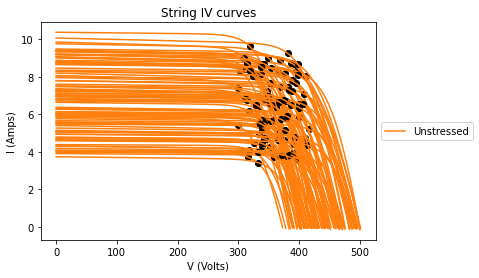

In [3]:
sim.visualize()

In [4]:
df = sim.sims_to_df(focus=['string'], cutoff=True)
df.head()

,current,voltage,E,T,mode,level
0,"[9.214203000284689, 9.210691359222285, 9.20726...","[3.834932371660216e-12, 11.207809937682319, 22...",1000.000000,50.000000,Unstressed,string
1,"[8.068736303190226, 8.059726147013295, 8.05093...","[3.836930773104541e-12, 10.101831916629767, 19...",893.237272,37.766397,Unstressed,string
2,"[5.830469114424021, 5.82726588572723, 5.824139...","[3.836930773104541e-12, 9.82298842686981, 19.4...",665.016420,36.287358,Unstressed,string
3,"[4.04621720624903, 4.042086488225943, 4.038054...","[3.836930773104541e-12, 9.95872777200447, 19.6...",422.334829,33.197140,Unstressed,string
4,"[8.823864279002581, 8.816063420981916, 8.80844...","[3.836930773104541e-12, 12.99701161628271, 25....",1022.942509,22.878509,Unstressed,string


### Step 2: Conduct diode parameter extraction

Given 5params: 9.099648 1.715049e-10 0.00470015 4.4285730999999995 0.02620368333333333
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2908.47it/s]
	Simulations completed after 8.68 seconds


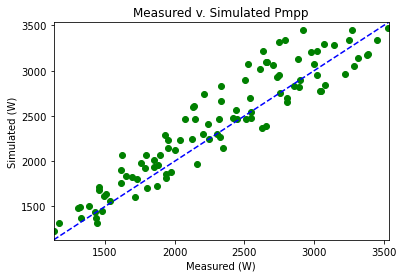

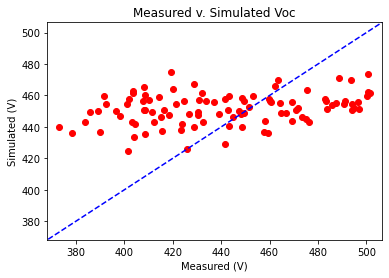

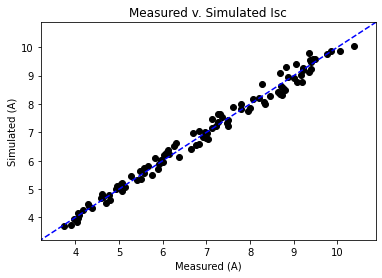

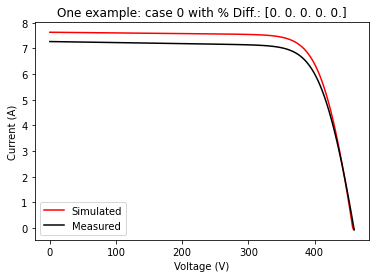

Params used in ^ iteration:  [9.09964800e+00 1.71504900e-10 4.70015000e-03 4.42857310e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2426.72it/s]
	Simulations completed after 9.51 seconds


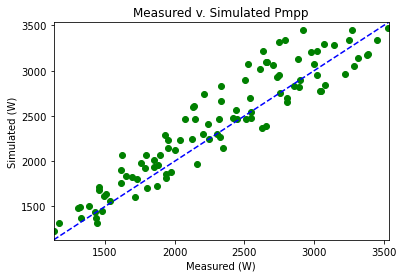

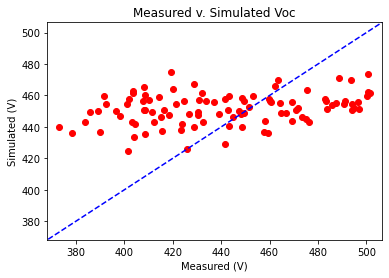

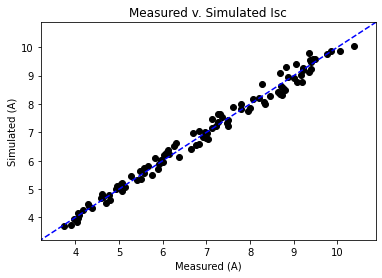

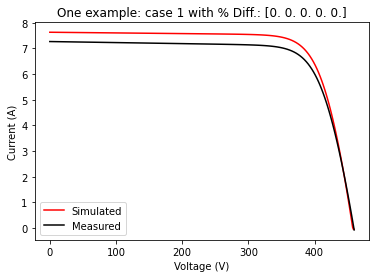

Params used in ^ iteration:  [9.09964800e+00 1.71504900e-10 4.70015000e-03 4.42857310e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2691.28it/s]
	Simulations completed after 9.25 seconds


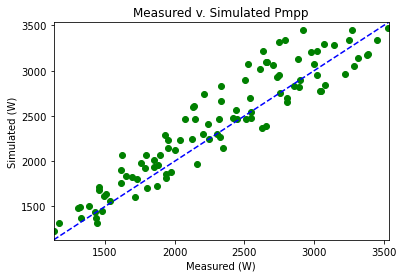

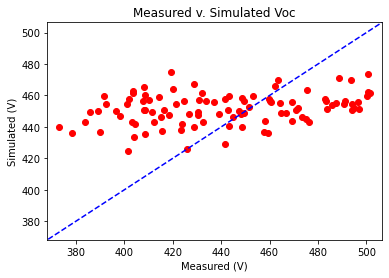

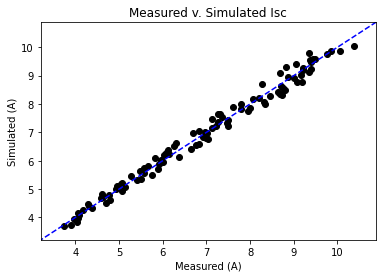

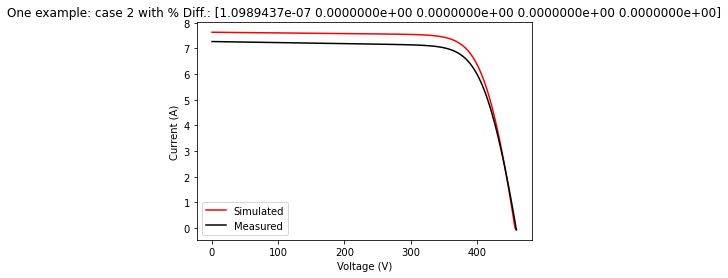

Params used in ^ iteration:  [9.09964801e+00 1.71504900e-10 4.70015000e-03 4.42857310e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 3598.47it/s]
	Simulations completed after 9.49 seconds


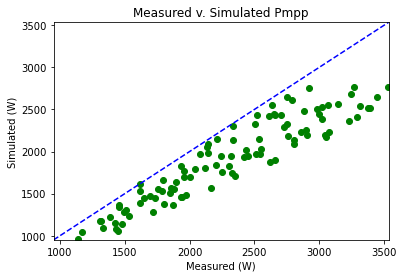

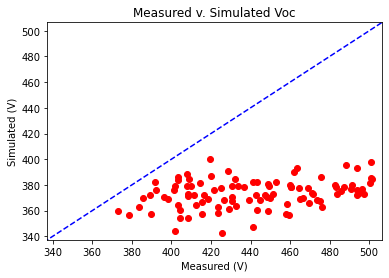

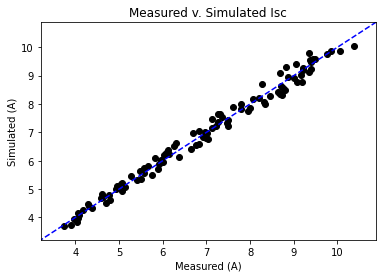

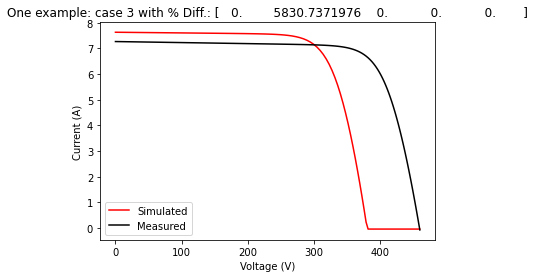

Params used in ^ iteration:  [9.09964800e+00 1.01715049e-08 4.70015000e-03 4.42857310e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 3526.57it/s]
	Simulations completed after 9.6 seconds


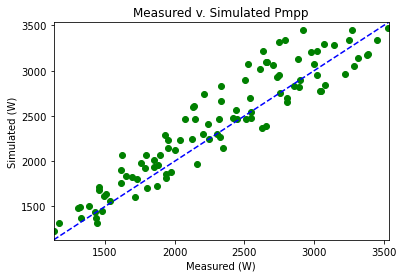

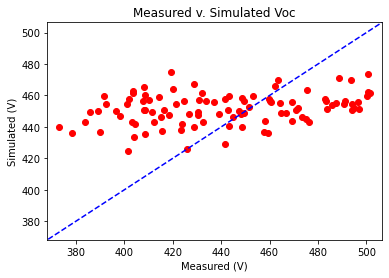

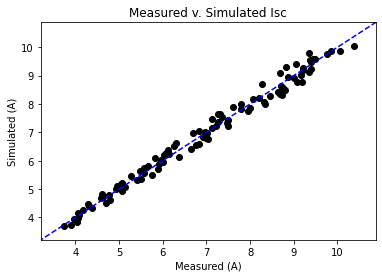

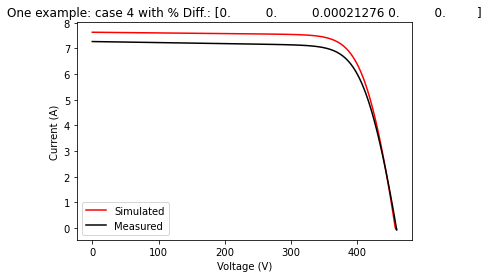

Params used in ^ iteration:  [9.09964800e+00 1.71504900e-10 4.70016000e-03 4.42857310e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2957.59it/s]
	Simulations completed after 10.45 seconds


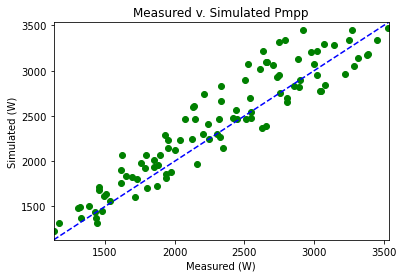

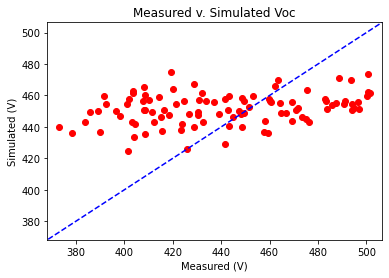

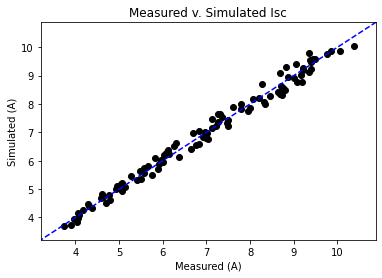

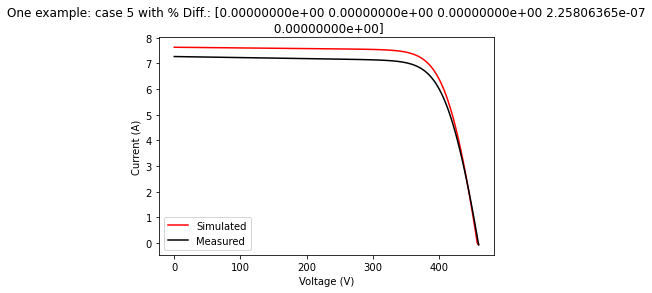

Params used in ^ iteration:  [9.09964800e+00 1.71504900e-10 4.70015000e-03 4.42857311e+00
 2.62036833e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2176.00it/s]
	Simulations completed after 11.26 seconds


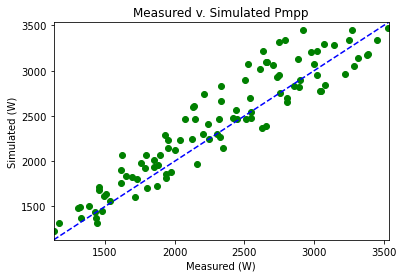

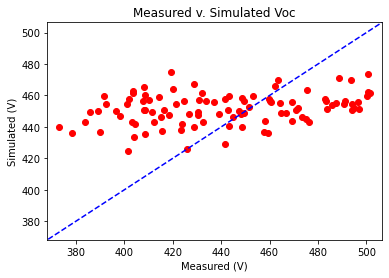

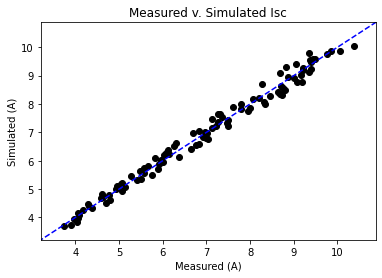

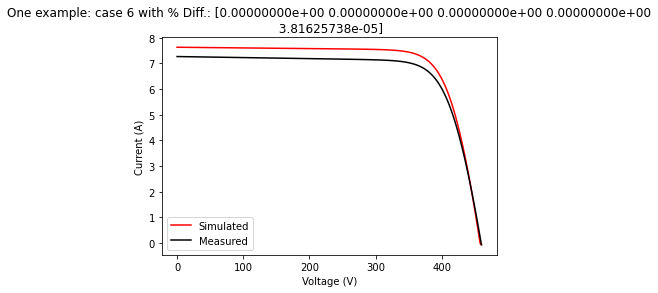

Params used in ^ iteration:  [9.09964800e+00 1.71504900e-10 4.70015000e-03 4.42857310e+00
 2.62036933e-02]
Simulating cells:   0%|          | 0/102 [00:00<?, ?it/s]C:\Users\mwhopwo\AppData\Local\Programs\Python\Python36\lib\site-packages\scipy\optimize\zeros.py:463: RuntimeWarning: some failed to converge after 100 iterations
  warnings.warn(msg, RuntimeWarning)
Adding up other definitions: 100%|██████████| 102/102 [00:00<00:00, 2691.35it/s]
	Simulations completed after 12.66 seconds
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



In [5]:
# Only created to retrieve cell_parameters
temporary_sim = simulator.Simulator(
                mod_specs = {
                            'Jinko_Solar_Co___Ltd_JKM270PP_60': {'ncols': 6,
                                                                    'nsubstrings': 3
                                                                }
                            }
)

extr = extractor.BruteForceExtractor(input_df=df, 
                              current_col='current',
                              voltage_col='voltage',
                              irradiance_col='E',
                              temperature_col='T',
                              T_type='cell',
                              windspeed_col=None,
                              Simulator_mod_specs=None,
                              Simulator_pristine_condition=None)

def bounds_func(iph,io,rs,rsh,nnsvth,perc_adjust=0.5):
    return ((iph - 0.5*iph*perc_adjust, iph + 2*iph*perc_adjust),
            (io - 40*io*perc_adjust, io + 40*io*perc_adjust),
            (rs - 20*rs*perc_adjust, rs + 20*rs*perc_adjust),
            (rsh - 150*rsh*perc_adjust, rsh + 150*rsh*perc_adjust),
            (nnsvth - 10*nnsvth*perc_adjust, nnsvth + 10*nnsvth*perc_adjust))

extr.fit_params(temporary_sim.cell_parameters,
                n_mods=12,
                user_func=None,
                bounds_func=bounds_func,
                perc_adjust=0.1,
                verbose=2)